# NeRF Activation Sparsity
Run the `accelerating_nerfs/nerf_activation_sparsity.py` script to compute the sparsities. You need to use the NeRF environment for that.

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from notebook_utils import load_mpl_style

load_mpl_style()

In [2]:
!ls ../accelerating_nerfs/sparsity

2023-05-03_00-00-30_sparsity.json  2023-05-03_18-13-41_volrend_sparsity.json
2023-05-03_00-21-28_sparsity.json


In [3]:
sparsity_results_path = "../accelerating_nerfs/sparsity/2023-05-03_00-21-28_sparsity.json"
with open(sparsity_results_path, "r") as f:
    sparsity_results = json.load(f)
skip_keys = ["overall"]

print(f"Loaded sparsity results for {sparsity_results.keys()}")

Loaded sparsity results for dict_keys(['chair', 'drums', 'ficus', 'hotdog', 'lego', 'materials', 'mic', 'ship', 'overall'])


In [4]:
processed_results = defaultdict(dict)
sparsity_key = 'avg_sparsity'
sparsity_std_key = 'std_sparsity'

for scene, results in sparsity_results.items():
    if scene in skip_keys:
        continue
        
    for layer_name, layer_result in results.items():
        _, num = layer_result["fc_label"].split("_")
        label = f"fc_{int(num) + 1}"
        processed_results[scene][label] = {
            "sparsity": layer_result[sparsity_key],
            "std": layer_result[sparsity_std_key] if sparsity_std_key else None
        }

## Plot input activation sparsity for each FC layer
Notes:

- `fc_1` is the layer that gets the position encoded ray sampels
- `fc_11` is the first hidden layer of the RGB MLP, that gets input from the bottleneck layer which doesn't have an activation function.

===== chair =====
Layers with sparsity: ['fc_2' 'fc_3' 'fc_4' 'fc_5' 'fc_6' 'fc_7' 'fc_8' 'fc_9' 'fc_10' 'fc_12']
mean sparsity over layers with sparsity: 0.5905425588917046
===== drums =====
Layers with sparsity: ['fc_2' 'fc_3' 'fc_4' 'fc_5' 'fc_6' 'fc_7' 'fc_8' 'fc_9' 'fc_10' 'fc_12']
mean sparsity over layers with sparsity: 0.6001014096139426
===== ficus =====
Layers with sparsity: ['fc_2' 'fc_3' 'fc_4' 'fc_5' 'fc_6' 'fc_7' 'fc_8' 'fc_9' 'fc_10' 'fc_12']
mean sparsity over layers with sparsity: 0.6097259715640105
===== hotdog =====
Layers with sparsity: ['fc_2' 'fc_3' 'fc_4' 'fc_5' 'fc_6' 'fc_7' 'fc_8' 'fc_9' 'fc_10' 'fc_12']
mean sparsity over layers with sparsity: 0.5977296720181926
===== lego =====
Layers with sparsity: ['fc_2' 'fc_3' 'fc_4' 'fc_5' 'fc_6' 'fc_7' 'fc_8' 'fc_9' 'fc_10' 'fc_12']
mean sparsity over layers with sparsity: 0.5805450992386703
===== materials =====
Layers with sparsity: ['fc_2' 'fc_3' 'fc_4' 'fc_5' 'fc_6' 'fc_7' 'fc_8' 'fc_9' 'fc_10' 'fc_12']
mean sparsit

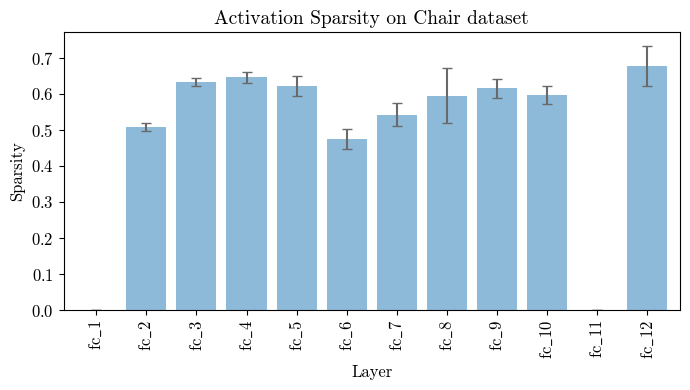

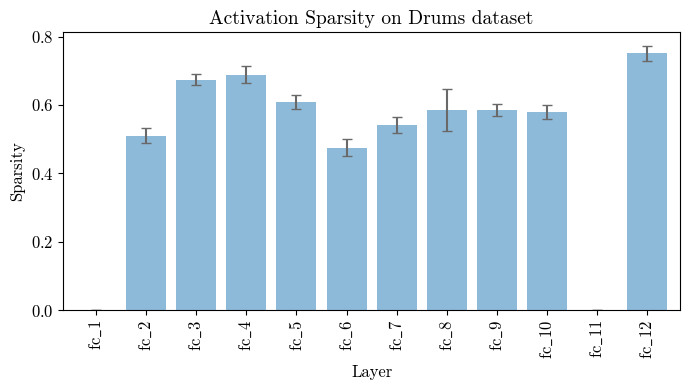

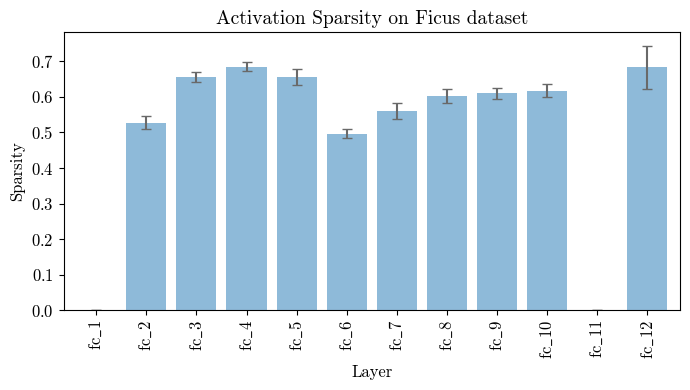

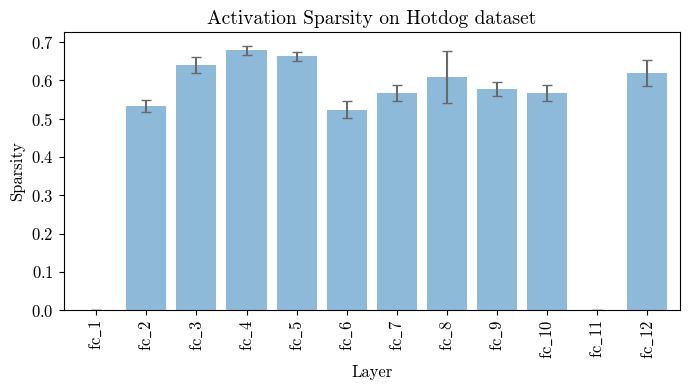

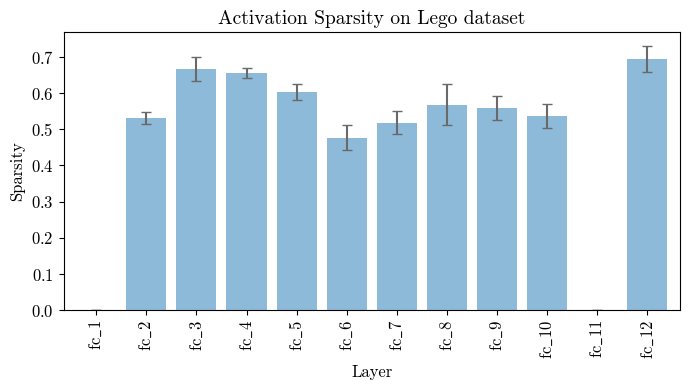

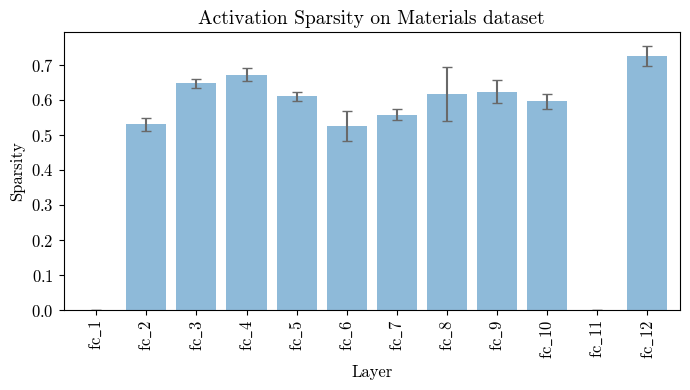

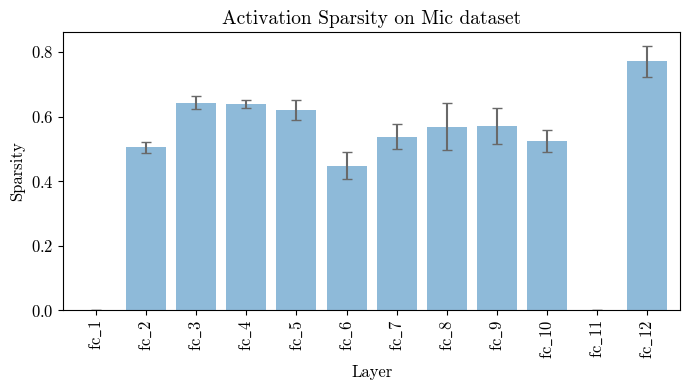

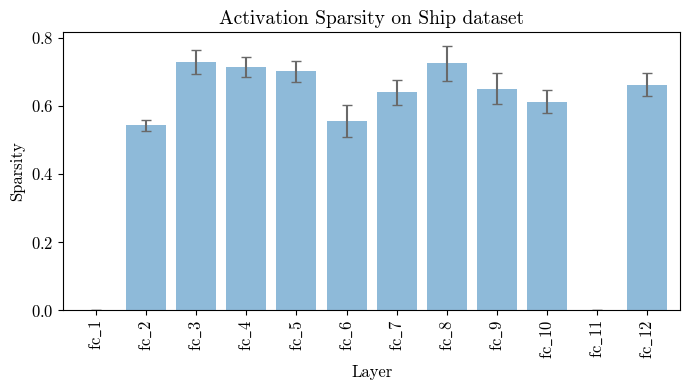

In [5]:
dfs = [pd.DataFrame.from_dict(results, orient="index") for results in processed_results.values()]
fig_dir = "figures/activation"
os.makedirs(fig_dir, exist_ok=True)
mean_sparsities = []

for label, df in zip(processed_results.keys(), dfs):
    err = df['std']
    ax = df.plot.bar(
        y="sparsity", yerr=err, width=0.8, figsize=(7, 4), 
        align='center', alpha=0.5, ecolor='dimgray', capsize=3.5
    )
    ax.set_xticklabels(["$\mathrm{fc}{\_}" + v.split("_")[1] + "$" for v in df.index.values])
    ax.get_legend().remove()
    ax.set_title(f"Activation Sparsity on {label.capitalize()} dataset")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Sparsity")
    ax.figure.tight_layout()
    ax.figure.savefig(f"{fig_dir}/{label}_sparsity.pdf")
    
    df_has_sparsity = df[df['sparsity'] > 0.01]
    
    print(f"===== {label} =====")
    print(f"Layers with sparsity: {df_has_sparsity.index.values}")
    mean_sparsity = df_has_sparsity['sparsity'].mean()
    print(f"mean sparsity over layers with sparsity: {mean_sparsity}")
    mean_sparsities.append(mean_sparsity)
    
print(f"Overall mean sparsity: {np.mean(mean_sparsities)}")